## Predicting Earthquake Building Damage
###### Haley Egan / vkb6bn 
###### DS 6040 / Summer 2022

### Introduction
In 2015 there was a 7.8 magnitude earthquake near Gorkha, Nepal. The damage devastated the community. About 9,000 people were killed, millions of people lost their homes, and there was about $10 billion in damage. The Nepalese government is still working to rebuild the affected area. During the years of recovery, the National Planning Commission, Kathmandu Living Labs, and the Central Bureau of Statistics have collected one of the largest post-disaster datasets ever. This data contains valuable information on earthquake structural damage and socio-economic impacts. 

This project is inspired by the Richter’s Predictor: Modeling Earthquake Damage data challenge hosted by DrivenData.org. The project harnesses the dataset on the 2015 Nepalese earthquake to model and predict the level of damage buildings suffered as a result of the earthquake. The insights gained from these predictions can be applied to future earthquakes, and ideally in preventing this level of devastation and fatalities from occurring again. 

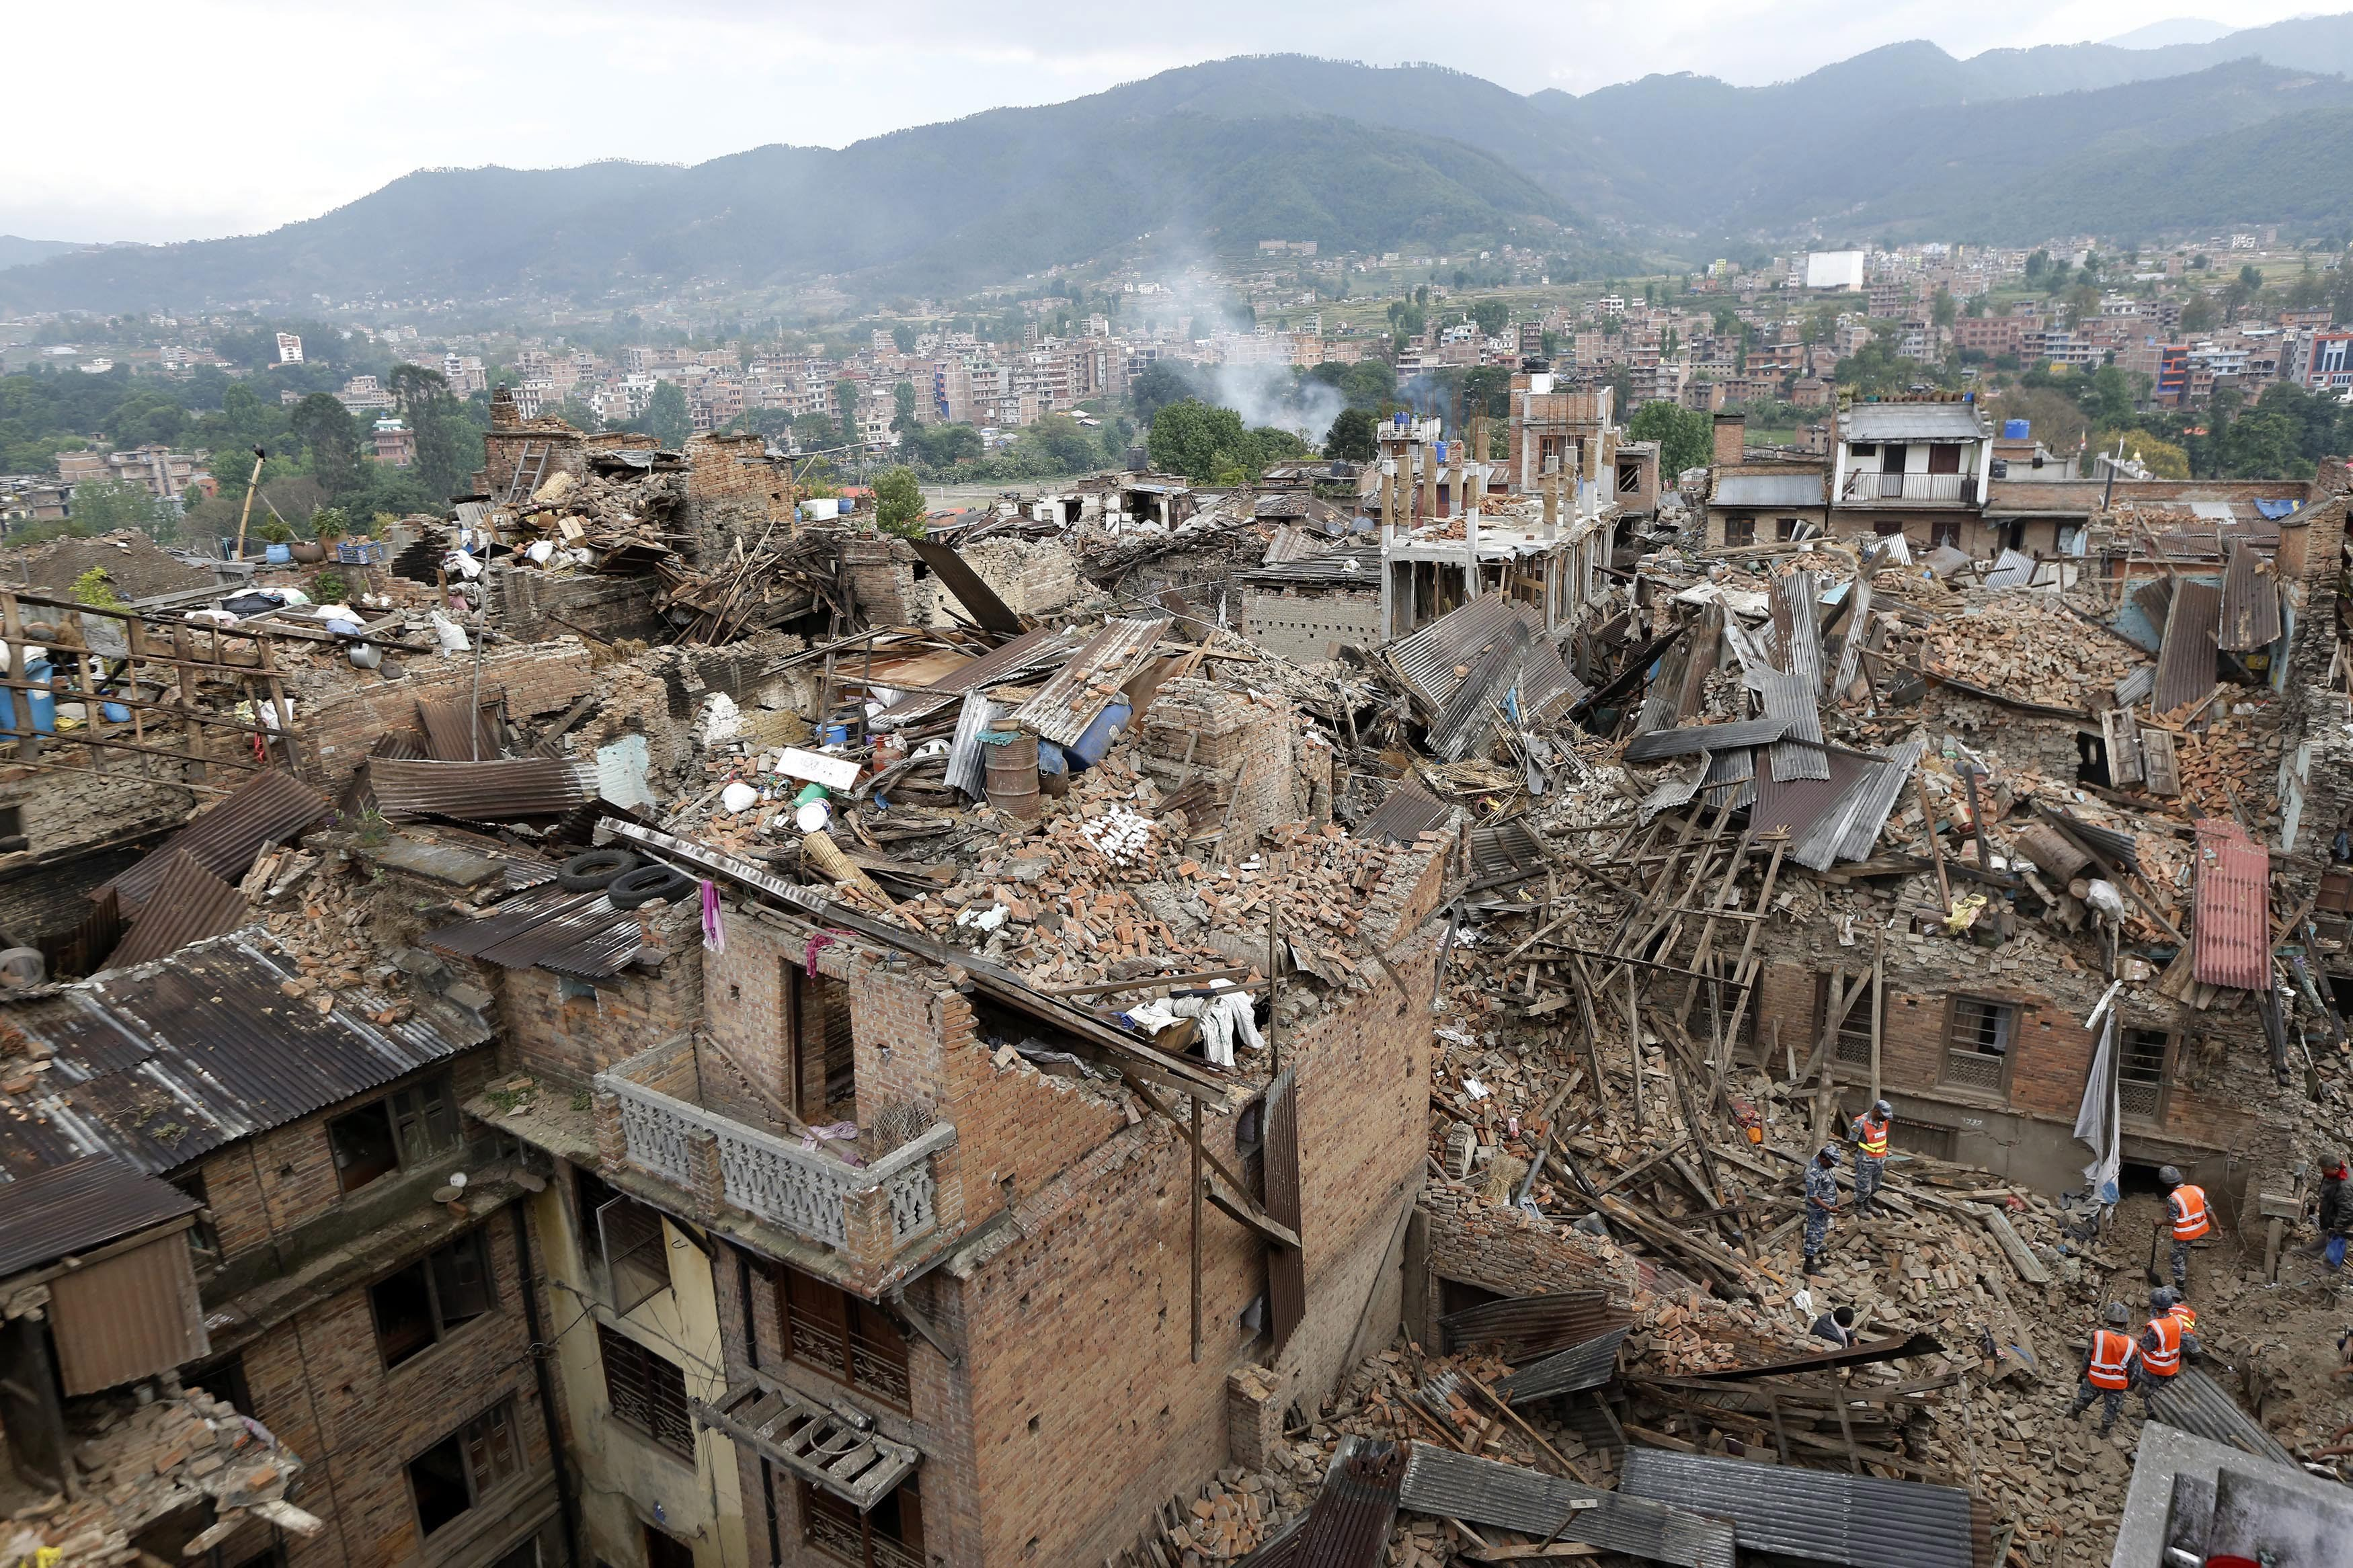

### Data
The data comes from the 2015 Nepal Earthquake Open Data Portal. The data contains 38 features, including structural information like number of floors, age of building, and type of foundation, as well as ownership status, building use, and number of families who lived there. Eight of the 38 features are categorical, resulting in mixed data types, which is addressed in the Data Cleaning & Preparation section. 

Each building has a unique id, and has a corresponding damage grade (1 = low damage, 2 = medium damage, 3 = complete destruction). This is a large dataset, with 208,480 individual buildings (rows) documented. The features are used to predict the damage level of each building on the test data set. 

For training and testing purposes, the full data set was split into a training data set, which contains 80% of the original data, and a testing data set, which contains the remaining 20% of the original data. All data cleaning, transformations, and feature reductions were applied to both the training and testing data sets. Model predictions were made on the training data set, and then tested with the testing data set, as is standard for this type of statistical analysis and modeling. 

### Model Selection
Bayesian Data Analysis techniques are used to model and predict this data set. Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and Logistic Regression are the models used and compared in this report to predict building damage levels. The data is processed and modeled in Python, using packages such as pymc, pandas, numpy, and sklearn. 

Markov chain Monte Carlo (MCMC) is used to find the posterior distribution of the model parameters (predictors and response). Trace plots of the MCMC sample are used to determine whether or not the sampler converges. The goal is to determine if there is evidence of divergent chains. Density plots are also used to visualize the posterior distributions for the parameters. 


### Priors
For LDA and QDA, there are two sets of priors used for each model. The first set of priors are gathered from initial observations of building damage through photos, videos, and articles of the 2015 earthquake. Based on this prior knowledge, it was initially observed that very few buildings experienced no or little damage (damage grade 1). Most buildings experienced some level of damage (damage grade 2), and many buildings experienced complete destruction (damage grade 3). Based on this prior knowledge, the damage grades were given the following prior value: damage grade 1 = 5%, damage grade 2 = 70%, damage grade 3 = 25%.   

The second set of priors are used as a comparison to the first priors, and are calculated from the observed proportion of building damage per level. While this method is not based on ‘prior knowledge’, it can help in the understanding of how well the initial priors performed. For damage grade 1, the observed proportion (buildings per grade/total buildings) for the training dataset is 0.0965, about 9.7%. For damage grade 2, the observed proportion for the training set is 0.5695, or about 57%. For damage grade 3, the observed proportion for the training set is 0.3339, or about 33.4%. 

### Feature Selection
The original dataset contains 38 features. After using one-hot encoding to transform the categorical variables into their own columns of binary 0/1 integers, there are 70 features, or columns. For Bayesian data analysis, this is too many features for the models to run efficiently. Based on observations gained from the exploratory data analysis, the full data set was reduced to 26 features. The removed features did not appear to add value to the predictions of building damage grade, and some were too highly correlated, which could skew the results. The reduced data set was used for the LDA, QDA, and Logistic Regression models. Bayesian Model Averaging was used to further reduce the features, but this did not improve the overall performance of the model. 


________________________________________________________________________________________________________________

### Data Cleaning & Preparation

After initial data cleaning and preparation, no missing data were found. 

In the original dataset, 30 of the predictors are integers (type: int64), and 8 are categorical (type: object). 'One-vs-the-rest', or one-hot encoding, was used to create new binary columns for the categorical predictors. For example, the predictor 'foundation_type' has values 'h', 'i', 'r', 'u', 'w', indicating which type of foundation each building (row) has. After one-hot encoding, each value becomes its own column, with a binary value of 0 (False), or 1 (True). This technique was performed for each categorical variable, resulting in 30 new columns in the dataset. 

Lastly, the response variable 'damage_grade' was transformed from an integer to a string, in order to perform LDA/QDA and Logistic Regression. For these models, classes are needed, requiring a categorical variable type. 

In [1]:
##import libraries
#data manipulation
import numpy as np
import pandas as pd

#ploting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import graphviz
import arviz as az
az.style.use("arviz-darkgrid")

#scientific & technical computing
from scipy.stats import multivariate_normal

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from statsmodels.tools import add_constant

#pymc
import pymc as pm
import bambi as bmb

#other
#from featurewiz import featurewiz #frequentist 
from pathlib import Path #filesystem paths
from mpmath import mp
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#training dataset 
#read in datasets, index by building id 
train_values = pd.read_csv('train_values.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

#merge 2 csv files into one complete csv file
data = train_values.merge(train_labels, on='building_id')
data.to_csv("complete_dataset.csv")

#read in complete csv file 
data = pd.read_csv("complete_dataset.csv")

In [3]:
#split data into 80% training data and 20% testing data
data, test_data = train_test_split(data, test_size=0.2)

In [114]:
data.head()

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
228413               4             651            8996                    1   
219972              10              70            1258                    2   
236615              15             535            8251                    2   
213786              20            1243            6397                    2   
192988              26            1110           10206                    2   

        age  area_percentage  height_percentage land_surface_condition  \
228413   10                3                  4                      n   
219972   15                5                  4                      t   
236615   15                4                  5                      t   
213786   50                9                  7                      t   
192988   10                6                  7                      t   

       foundation_type roof_type  ... has_secondary_use_hotel  \
228413               r         n  ...                       0   
219972               r         n  ...                       0   
236615               r         n  ...                       0   
213786               r         q  ...                       0   
192988               r         n  ...                       0   

       has_secondary_use_rental has_secondary_use_institution  \
228413                        0                             0   
219972                        0                             0   
236615                        0                             0   
213786                        0                             0   
192988                        0                             0   

       has_secondary_use_school  has_secondary_use_industry  \
228413                        0                           0   
219972                        0                           0   
236615                        0                           0   
213786                        0                           0   
192988                        0                           0   

        has_secondary_use_health_post  has_secondary_use_gov_office  \
228413                              0                             0   
219972                              0                             0   
236615                              0                             0   
213786                              0                             0   
192988                              0                             0   

        has_secondary_use_use_police  has_secondary_use_other  damage_grade  
228413                             0                        0             3  
219972                             0                        0             2  
236615                             0                        0             2  
213786                             0                        0             2  
192988                             0                        0             2  

[5 rows x 39 columns]

In [5]:
#test_data.head()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
205402       982740              17            1026            4627   
255480       838136              20             508             581   
10017        735826              21            1355            4568   
46130         47649              20             173            2261   
36489        611545              27            1000            4403   

        count_floors_pre_eq  age  area_percentage  height_percentage  \
205402                    2   25                5                  4   
255480                    1    0               10                  3   
10017                     3   15                6                  7   
46130                     1    0               15                  3   
36489                     2   30                8                  5   

       land_surface_condition foundation_type  ... has_secondary_use_hotel  \
205402                      t               r  ...                       0   
255480                      t               w  ...                       0   
10017                       t               r  ...                       0   
46130                       t               i  ...                       0   
36489                       t               r  ...                       0   

       has_secondary_use_rental has_secondary_use_institution  \
205402                        0                             0   
255480                        0                             0   
10017                         0                             0   
46130                         0                             0   
36489                         0                             0   

       has_secondary_use_school has_secondary_use_industry  \
205402                        0                          0   
255480                        0                          0   
10017                         0                          0   
46130                         0                          0   
36489                         0                          0   

        has_secondary_use_health_post  has_secondary_use_gov_office  \
205402                              0                             0   
255480                              0                             0   
10017                               0                             0   
46130                               0                             0   
36489                               0                             0   

        has_secondary_use_use_police  has_secondary_use_other  damage_grade  
205402                             0                        0             3  
255480                             0                        0             2  
10017                              0                        0             2  
46130                              0                        0             1  
36489                              0                        0             3  

[5 rows x 40 columns]

In [6]:
#drop building_id, since it is not needed for analysis
data = data.drop(['building_id'], axis=1) #apply to training data 
test_data = test_data.drop(['building_id'], axis=1) #apply to test data

In [7]:
#check for missing data
#data.isnull().sum()

#check data types 
#data.dtypes

In [8]:
#make copy of dataframe
data_transformed = data

In [9]:
#one-hot encoding of categorical variables
data_transformed = pd.get_dummies(data_transformed) #apply to training data 
test_data = pd.get_dummies(test_data) #apply to test data

In [93]:
#data_transformed.head()

In [94]:
#test_data.head()

In [12]:
#change 'damage_grade' from int to str for LDA/QDA and Logistic Regression 
data_transformed['damage_grade'].apply(str)
data_transformed['damage_grade'] = data_transformed['damage_grade'].apply(str) #apply to training data 
test_data['damage_grade'].apply(str)
test_data['damage_grade'] = test_data['damage_grade'].apply(str) #apply to test data

____________________________________________________________________________________________________________________________

### Exploratory Data Analysis (EDA)

EDA was performed to gain initial insights into the data and their interactions. From a basic bar plot of each damage grade, it becomes apparent that most buildings have a damage grade of 2, with the second highest level of damage at grade 3. There are over 140,000 buildings that had medium damage, about 90,000 that had complete destruction, and only about 25,000 that had low damage. 

Comparisons between damage grade and other predictors reveal which predictors may be most important. For example, the age of a building has some influence on the level of damage. Of all the predictors, the type of superstructure (materials of building that is above ground), appears to play the largest role in the level of damage of the earthquake to the building. Most buildings made of adobe mud experienced damage grade 3, complete destruction, while most buildings made of bamboo experienced damage grade 1, low damage. 'Foundataion_type_r' and 'foundation_type_h' also appear to be significant when assessing damage. Buildings with the highest damage grade most frequently have 'foundation_type_r' and 'foundation_type_h'. 

When looking at overall correlation of all the predictors, there does not appear to be any significant correlation. This suggests that most, if not all, of the predictors can be used for modeling and predictions without skewing the results. 

<AxesSubplot:title={'center':'Number of Buildings with Each Damage Grade'}>

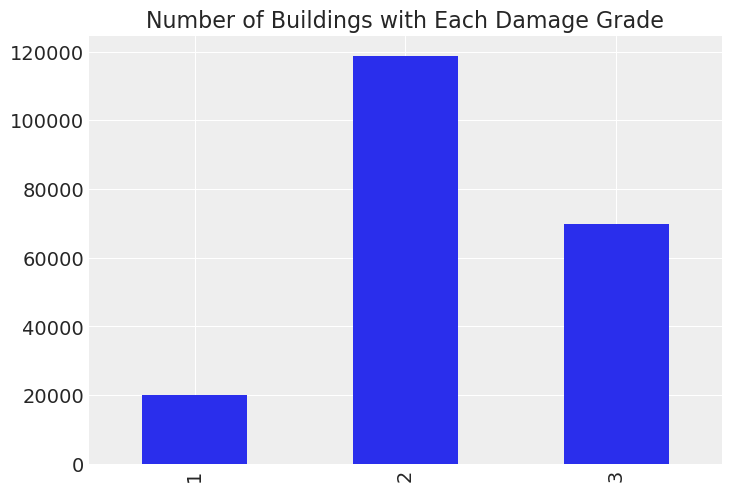

In [13]:
#barplot of overall damage grade
(data.damage_grade.value_counts().sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"))

<AxesSubplot:xlabel='damage_grade', ylabel='count_floors_pre_eq'>

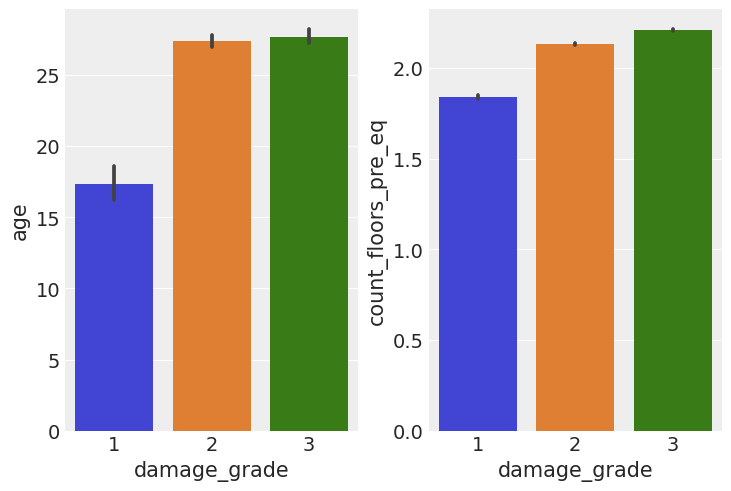

In [106]:
fig, axs = plt.subplots(ncols=2)
sns.barplot(x='damage_grade', y='age', data=data, ax=axs[0])
sns.barplot(x='damage_grade', y='count_floors_pre_eq', data=data, ax=axs[1])

<AxesSubplot:xlabel='damage_grade', ylabel='foundation_type'>

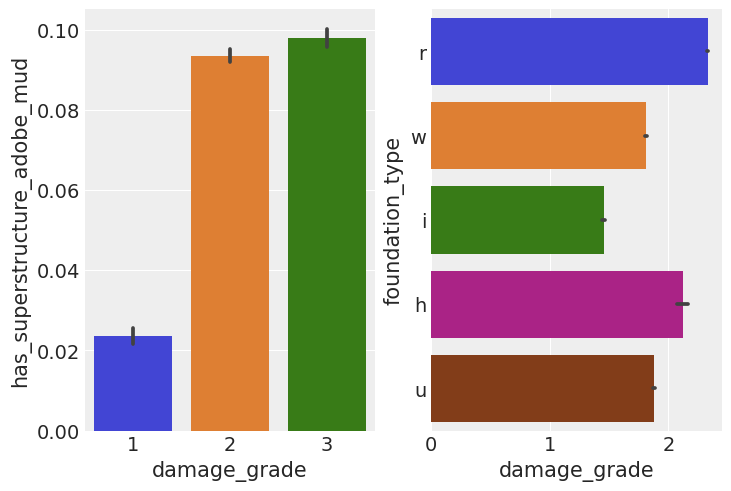

In [107]:
fig, axs = plt.subplots(ncols=2)
sns.barplot(x='damage_grade', y='has_superstructure_adobe_mud', data=data, ax=axs[0])
sns.barplot(x='damage_grade',y='foundation_type', data=data, ax=axs[1])

<AxesSubplot:xlabel='damage_grade', ylabel='has_superstructure_mud_mortar_stone'>

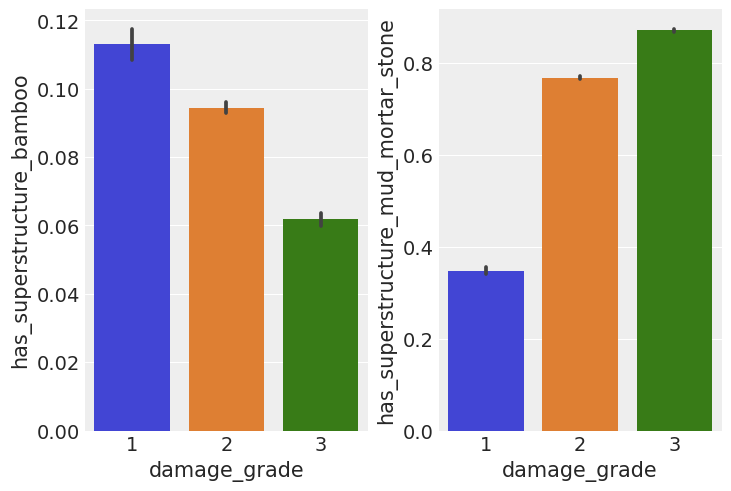

In [108]:
fig, axs = plt.subplots(ncols=2)
sns.barplot(x='damage_grade', y='has_superstructure_bamboo', data=data, ax=axs[0])
sns.barplot(x='damage_grade',y='has_superstructure_mud_mortar_stone', data=data, ax=axs[1])

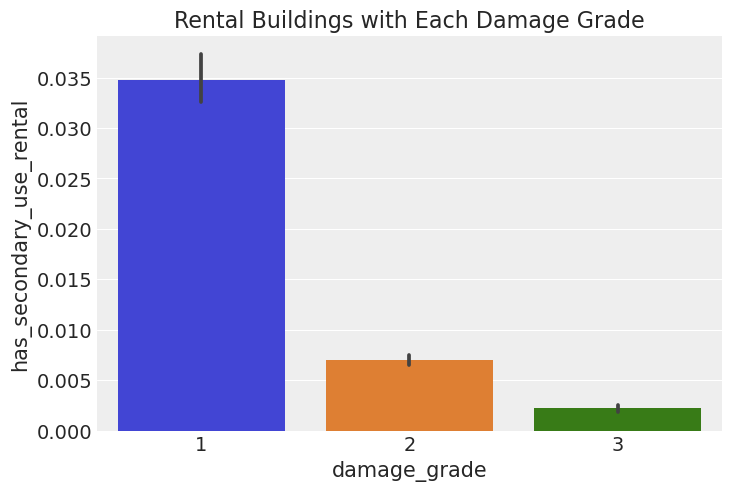

In [20]:
ax4 = sns.barplot(x="damage_grade", y="has_secondary_use_rental", data=data).set(title='Rental Buildings with Each Damage Grade')

In [21]:
data.corr()

geo_level_1_id  geo_level_2_id  \
geo_level_1_id                                1.000000       -0.061254   
geo_level_2_id                               -0.061254        1.000000   
geo_level_3_id                                0.002393        0.000960   
count_floors_pre_eq                          -0.089062        0.047249   
age                                          -0.003007        0.013158   
area_percentage                               0.071513       -0.049553   
height_percentage                            -0.062625        0.034604   
has_superstructure_adobe_mud                 -0.018421        0.014786   
has_superstructure_mud_mortar_stone          -0.152315        0.076233   
has_superstructure_stone_flag                 0.008779       -0.010159   
has_superstructure_cement_mortar_stone        0.023460       -0.009664   
has_superstructure_mud_mortar_brick          -0.030496        0.013349   
has_superstructure_cement_mortar_brick        0.135256       -0.080541   
has_superstructure_timber                     0.145780       -0.023562   
has_superstructure_bamboo                     0.074184       -0.032604   
has_superstructure_rc_non_engineered          0.016232       -0.037336   
has_superstructure_rc_engineered              0.016409       -0.034944   
has_superstructure_other                      0.021393       -0.022133   
count_families                                0.034923       -0.012633   
has_secondary_use                            -0.011265        0.000074   
has_secondary_use_agriculture                -0.020555        0.018678   
has_secondary_use_hotel                       0.001924       -0.007861   
has_secondary_use_rental                      0.023209       -0.029388   
has_secondary_use_institution                 0.004315       -0.005484   
has_secondary_use_school                      0.002717       -0.006278   
has_secondary_use_industry                    0.003024        0.001552   
has_secondary_use_health_post                -0.001112       -0.002829   
has_secondary_use_gov_office                  0.002175       -0.000915   
has_secondary_use_use_police                 -0.000884        0.001592   
has_secondary_use_other                      -0.018599       -0.012539   
damage_grade                                 -0.072622        0.042790   

                                        geo_level_3_id  count_floors_pre_eq  \
geo_level_1_id                                0.002393            -0.089062   
geo_level_2_id                                0.000960             0.047249   
geo_level_3_id                                1.000000            -0.022531   
count_floors_pre_eq                          -0.022531             1.000000   
age                                          -0.006684             0.086712   
area_percentage                              -0.004810             0.100063   
height_percentage                            -0.025999             0.771870   
has_superstructure_adobe_mud                 -0.016838             0.175420   
has_superstructure_mud_mortar_stone           0.027532            -0.027359   
has_superstructure_stone_flag                 0.019376            -0.041549   
has_superstructure_cement_mortar_stone        0.005477            -0.011003   
has_superstructure_mud_mortar_brick          -0.021930             0.256215   
has_superstructure_cement_mortar_brick       -0.005310            -0.087485   
has_superstructure_timber                    -0.003686            -0.056857   
has_superstructure_bamboo                     0.005867            -0.069924   
has_superstructure_rc_non_engineered          0.000284             0.009445   
has_superstructure_rc_engineered             -0.012584             0.047556   
has_superstructure_other                     -0.012041            -0.030596   
count_families                               -0.002271             0.085664   
has_secondary_use                             0.008362             0.051653   
has_secondar

In [22]:
#Descriptive Statistics
data.describe()

geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  \
count   208480.000000   208480.000000   208480.000000        208480.000000   
mean        13.902043      700.797885     6257.740762             2.130046   
std          8.034122      412.550241     3646.821631             0.726627   
min          0.000000        0.000000        0.000000             1.000000   
25%          7.000000      350.000000     3073.000000             2.000000   
50%         12.000000      701.000000     6264.000000             2.000000   
75%         21.000000     1050.000000     9413.250000             2.000000   
max         30.000000     1427.000000    12567.000000             9.000000   

                 age  area_percentage  height_percentage  \
count  208480.000000    208480.000000      208480.000000   
mean       26.555161         8.020491           5.435903   
std        73.679085         4.387338           1.914143   
min         0.000000         1.000000           2.000000   
25%        10.000000         5.000000           4.000000   
50%        15.000000         7.000000           5.000000   
75%        30.000000         9.000000           6.000000   
max       995.000000       100.000000          32.000000   

       has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  \
count                 208480.000000                        208480.000000   
mean                       0.088181                             0.761953   
std                        0.283559                             0.425889   
min                        0.000000                             0.000000   
25%                        0.000000                             1.000000   
50%                        0.000000                             1.000000   
75%                        0.000000                             1.000000   
max                        1.000000                             1.000000   

       has_superstructure_stone_flag  ...  has_secondary_use_hotel  \
count                  208480.000000  ...            208480.000000   
mean                        0.034080  ...                 0.033485   
std                         0.181435  ...                 0.179900   
min                         0.000000  ...                 0.000000   
25%                         0.000000  ...                 0.000000   
50%                         0.000000  ...                 0.000000   
75%                         0.000000  ...                 0.000000   
max                         1.000000  ...                 1.000000   

       has_secondary_use_rental  has_secondary_use_institution  \
count             208480.000000                  208480.000000   
mean                   0.008054                       0.000979   
std                    0.089380                       0.031266   
min                    0.000000                       0.000000   
25%                    0.000000                       0.000000   
50%                    0.000000                       0.000000   
75%                    0.000000                       0.000000   
max                    1.000000                       1.000000   

       has_secondary_use_school  has_secondary_use_industry  \
count             208480.000000               208480.000000   
mean                   0.000350                    0.001074   
std                    0.018709                    0.032761   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    0.000000                    0.000000   
75%                    0.000000                    0.000000   
max                    1.000000                    1.000000   

       has_secondary_use_health_post  has_secondary_use_gov_office  \
count                  208480.000000                 208480.000000   
mean                        0.000173                      0.000153   
std                         0.013140                      0.012388   
min 

In [23]:
#Descriptive Statistics for training data
#Mean by Group
data_transformed.groupby('damage_grade').mean()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
damage_grade                                                   
1                  17.339640      652.805221     6265.909200   
2                  13.368245      698.042474     6218.463697   
3                  13.823195      719.274599     6322.252258   

              count_floors_pre_eq        age  area_percentage  \
damage_grade                                                    
1                        1.840264  17.350621         9.727300   
2                        2.132281  27.421299         8.037234   
3                        2.209484  27.724913         7.501692   

              height_percentage  has_superstructure_adobe_mud  \
damage_grade                                                    
1                      5.143713                      0.023611   
2                      5.434769                      0.093413   
3                      5.521767                      0.097823   

              has_superstructure_mud_mortar_stone  \
damage_grade                                        
1                                        0.348126   
2                                        0.768021   
3                                        0.870501   

              has_superstructure_stone_flag  ...  plan_configuration_m  \
damage_grade                                 ...                         
1                                  0.006639  ...              0.000349   
2                                  0.030613  ...              0.000227   
3                                  0.047865  ...              0.000057   

              plan_configuration_n  plan_configuration_o  \
damage_grade                                               
1                         0.000300              0.001697   
2                         0.000126              0.000665   
3                         0.000143              0.000287   

              plan_configuration_q  plan_configuration_s  \
damage_grade                                               
1                         0.030600              0.001947   
2                         0.017497              0.001525   
3                         0.026499              0.000803   

              plan_configuration_u  legal_ownership_status_a  \
damage_grade                                                   
1                          0.03050                  0.060650   
2                          0.01641                  0.020597   
3                          0.00542                  0.010941   

              legal_ownership_status_r  legal_ownership_status_v  \
damage_grade                                                       
1                             0.007937                  0.926272   
2                             0.004962                  0.965495   
3                             0.006281                  0.968482   

              legal_ownership_status_w  
damage_grade                            
1                             0.005142  
2                             0.008946  
3                             0.014296  

[3 rows x 68 columns]

In [24]:
#Descriptive Statistics for testing data
#Mean by Group
test_data.groupby('damage_grade').mean()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
damage_grade                                                   
1                  17.234139      653.444117     6325.555294   
2                  13.361929      699.004433     6225.941658   
3                  13.819451      721.748055     6293.764874   

              count_floors_pre_eq        age  area_percentage  \
damage_grade                                                    
1                        1.845413  17.201925         9.671577   
2                        2.129679  27.024027         8.021252   
3                        2.208753  28.186499         7.501945   

              height_percentage  has_superstructure_adobe_mud  \
damage_grade                                                    
1                      5.161658                      0.023767   
2                      5.422606                      0.095195   
3                      5.515332                      0.102002   

              has_superstructure_mud_mortar_stone  \
damage_grade                                        
1                                        0.350815   
2                                        0.770761   
3                                        0.866533   

              has_superstructure_stone_flag  ...  plan_configuration_m  \
damage_grade                                 ...                         
1                                  0.009625  ...              0.000196   
2                                  0.030457  ...              0.000237   
3                                  0.051087  ...              0.000000   

              plan_configuration_n  plan_configuration_o  \
damage_grade                                               
1                         0.000000              0.001179   
2                         0.000169              0.000575   
3                         0.000114              0.000172   

              plan_configuration_q  plan_configuration_s  \
damage_grade                                               
1                         0.032999              0.002750   
2                         0.017191              0.001421   
3                         0.027346              0.000801   

              plan_configuration_u  legal_ownership_status_a  \
damage_grade                                                   
1                         0.032017                  0.058142   
2                         0.015262                  0.021286   
3                         0.005606                  0.009382   

              legal_ownership_status_r  legal_ownership_status_v  \
damage_grade                                                       
1                             0.010607                  0.925948   
2                             0.004670                  0.965854   
3                             0.005435                  0.971110   

              legal_ownership_status_w  
damage_grade                            
1                             0.005303  
2                             0.008190  
3                             0.014073  

[3 rows x 68 columns]

In [25]:
#Overall Covariance Matrix for training data
data_transformed.cov()

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
geo_level_1_id                 64.547113     -203.025612    7.011329e+01   
geo_level_2_id               -203.025612   170197.701085    1.444371e+03   
geo_level_3_id                 70.113286     1444.370673    1.329931e+07   
count_floors_pre_eq            -0.519929       14.163732   -5.970451e+01   
age                            -1.780230      399.951889   -1.795850e+03   
...                                  ...             ...             ...   
plan_configuration_u            0.031450       -1.308935    1.083531e+00   
legal_ownership_status_a        0.115428       -1.483517    1.913897e+01   
legal_ownership_status_r        0.004946       -0.822386   -2.249845e-01   
legal_ownership_status_v       -0.124752        1.780315   -1.351657e+01   
legal_ownership_status_w        0.004378        0.525588   -5.397414e+00   

                          count_floors_pre_eq          age  area_percentage  \
geo_level_1_id                      -0.519929    -1.780230         2.520731   
geo_level_2_id                      14.163732   399.951889       -89.691588   
geo_level_3_id                     -59.704515 -1795.849677       -76.964646   
count_floors_pre_eq                  0.527987     4.642321         0.318998   
age                                  4.642321  5428.607609        -1.144209   
...                                       ...          ...              ...   
plan_configuration_u                -0.000412    -0.017520         0.050556   
legal_ownership_status_a            -0.010203    -0.263520        -0.019204   
legal_ownership_status_r            -0.000519    -0.011821        -0.004932   
legal_ownership_status_v             0.010105     0.252472         0.025519   
legal_ownership_status_w             0.000618     0.022869        -0.001383   

                          height_percentage  has_superstructure_adobe_mud  \
geo_level_1_id                    -0.963075                     -0.041967   
geo_level_2_id                    27.325724                      1.729679   
geo_level_3_id                  -181.487782                    -17.412215   
count_floors_pre_eq                1.073570                      0.036144   
age                                8.502639                      1.392058   
...                                     ...                           ...   
plan_configuration_u               0.001390                      0.000691   
legal_ownership_status_a          -0.021997                     -0.001252   
legal_ownership_status_r          -0.001305                      0.000520   
legal_ownership_status_v           0.022848                     -0.000186   
legal_ownership_status_w           0.000454                      0.000918   

                          has_superstructure_mud_mortar_stone  \
geo_level_1_id                                      -0.521167   
geo_level_2_id                                      13.394243   
geo_level_3_id                                      42.761144   
count_floors_pre_eq                                 -0.008466   
age                                                  0.036236   
...                                                       ...   
plan_configuration_u                                -0.004949   
legal_ownership_status_a                            -0.008601   
legal_ownership_status_r                            -0.001557   
legal_ownership_status_v                             0.010285   
legal_ownership_status_w                            -0.000126   

                          has_superstructure_stone_flag  ...  \
geo_level_1_id                                 0.012797  ...   
geo_level_2_id                                -0.760431  ...   
geo_level_3_id                                12.820408  ...   
count_floors_pre_eq                           -0.005478  ...   
age                                            0.129584  ...   
...                                                 ...  ...   
plan_confi

In [95]:
#Overall Covariance Matrix for testing data
#test_data.cov()

In [27]:
#reduce dataset from 38 features to 26 features
reduced_data = data_transformed[['damage_grade', 'foundation_type_r', 'has_superstructure_mud_mortar_stone', 'geo_level_1_id', 'ground_floor_type_v', 'has_superstructure_cement_mortar_brick', 'other_floor_type_q', 'age', 'has_superstructure_stone_flag', 'roof_type_x', 'has_superstructure_adobe_mud', 'other_floor_type_j', 'count_floors_pre_eq', 'foundation_type_w', 'position_s', 'foundation_type_u', 'foundation_type_h', 'other_floor_type_x', 'legal_ownership_status_v', 'legal_ownership_status_w', 'roof_type_n', 'plan_configuration_u', 'has_secondary_use', 'land_surface_condition_t', 'plan_configuration_d', 'legal_ownership_status_r']] 
reduced_test_data = test_data[['damage_grade', 'foundation_type_r', 'has_superstructure_mud_mortar_stone', 'geo_level_1_id', 'ground_floor_type_v', 'has_superstructure_cement_mortar_brick', 'other_floor_type_q', 'age', 'has_superstructure_stone_flag', 'roof_type_x', 'has_superstructure_adobe_mud', 'other_floor_type_j', 'count_floors_pre_eq', 'foundation_type_w', 'position_s', 'foundation_type_u', 'foundation_type_h', 'other_floor_type_x', 'legal_ownership_status_v', 'legal_ownership_status_w', 'roof_type_n', 'plan_configuration_u', 'has_secondary_use', 'land_surface_condition_t', 'plan_configuration_d', 'legal_ownership_status_r']]
#duplicated reduced_data and name 'predictors'
predictors = reduced_data.drop(['damage_grade'], axis=1)
predictors_test_data = reduced_test_data.drop(['damage_grade'], axis=1)

____________________________________________________________________________________________________________________________

## Models

### Linear Discriminant Analysis (LDA)
Linear Discriminant Analysis (LDA) estimates the probability that a new set of inputs belongs to appropriate damage grade class (1, 2, or 3). LDA models the likelihood of each damage grade class as a Gaussian distribution. LDA then uses the posterior distributions to estimate the class for each test point (Srivastava et al., 2007).


In [28]:
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        mis_class =  1 - maps['Mis_class'].mean()
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs

#### Priors based on Observational Knowledge

In [29]:
LDA_1 = LDA(reduced_data, 'damage_grade', priors = [0.05, 0.70, 0.25])
LDA_1.priors

array([0.05, 0.7 , 0.25])

In [30]:
#probability prediction
LDA_1.predict_probs(reduced_data).head()

1         2         3 True Class
0  0.015511  0.738469  0.246021          3
1  0.010712  0.755685  0.233603        NaN
2  0.012290  0.738209  0.249501          3
3  0.012629  0.624838  0.362533          2
4  0.016538  0.696463  0.286999          3

In [31]:
#map class to true class
LDA_1.predict_MAP(reduced_data).head()

MAP Class True Class
0         2          3
1         2        NaN
2         2          3
3         2          2
4         2          3

In [32]:
#misclassification rate
LDA_1.misclass_rate()

0.5609363008442056

In [33]:
#cross-tabs table showing which categories are being classified correctly vs. incorrectly
LDA_1.misclass_xtabs()

True Class      1      2      3
MAP Class                      
1             648   4065   2299
2           15314  90801  53411
3              22    151     87

#### Test Data

In [34]:
#Misclassification Rate for testing data
LDA_1.misclass_rate(reduced_test_data)

0.8910995568005219

In [35]:
#Cross-tabs for testing data
LDA_1.misclass_xtabs(reduced_test_data)

True Class    1     2     3
MAP Class                  
1            48   264   144
2           969  5624  3328
3             2     3     4

____________________________________________________________________________________________________________________________

#### Observed Proportion of Damage Grades

In [36]:
#number of buildings per damage grade in reduced dataset
reduced_data['damage_grade'].value_counts()

2    118709
3     69738
1     20033
Name: damage_grade, dtype: int64

In [37]:
#total length of reduced dataset 
len(reduced_data)

208480

In [96]:
LDA_prop = LDA(reduced_data, 'damage_grade', priors = [20127/208480, 118733/208480, 69620/208480])
LDA_prop.priors

array([0.09654163, 0.56951746, 0.33394091])

In [41]:
#prediction
LDA_prop.predict_probs(reduced_data).head()

1         2         3 True Class
0  0.031216  0.626248  0.342536          3
1  0.021827  0.648859  0.329314        NaN
2  0.024780  0.627192  0.348028          3
3  0.023977  0.499864  0.476159          2
4  0.032519  0.577065  0.390417          3

In [42]:
#map class to true class
LDA_prop.predict_MAP(reduced_data).head()

MAP Class True Class
0         2          3
1         2        NaN
2         2          3
3         2          2
4         2          3

In [43]:
#misclassification rate
LDA_prop.misclass_rate()

0.5797006907137375

In [44]:
#cross-tabs table showing which categories are being classified correctly vs. incorrectly
LDA_prop.misclass_xtabs()

True Class      1      2      3
MAP Class                      
1            1022   6420   3678
2           14202  83979  49496
3             760   4618   2623

#### Test Data

In [45]:
#Misclassification Rate for testing data
LDA_prop.misclass_rate(reduced_test_data)

0.8949175955948658

In [46]:
#Cross-tabs for testing data
LDA_prop.misclass_xtabs(reduced_test_data)

True Class    1     2     3
MAP Class                  
1            80   393   237
2           879  5223  3065
3            60   275   174

### Analysis of LDA Model
When using priors gained from observations of earthquake photos and videos, the LDA model performed better than when using observed proportion priors (actual number of building per grade divided by total number of buildings). For the first set of priors, the misclassification error rate was 56.1% on the training data, and 88.9% on the testing data. Therefore, the accuracy rate on the training data  is 43.9%, and 11.1% on the testing data. 

For the second set of priors from observed proportions, the misclassification error rate was 57.9% on the training data, and 89.3% on the testing data. Therefore, the accuracy rate on the training data was 42.1%, and 10.7% on the testing data. While both sets of priors had similar results, the first priors (from prior knowledge) perform slightly better on the training and testing data. That being said, the overall misclassification rate is very high, and the accuracy rate very low. The data suggests that nearly 90% of the test data set is being wrongly classified. This suggests that LDA is likely not the best model to use for predicting the damage grade of buildings from the earthquake. 


____________________________________________________________________________________________________________________________

### Quadratic Discriminant Analysis (QDA)
Similarly to LDA, Quadratic Discriminant Analysis (QDA) estimates the probability that a new set of inputs belongs to appropriate damage grade class (1, 2, or 3). QDA also models the likelihood of each damage grade class as a Gaussian distribution, and then uses the posterior distributions to estimate the class for each test point (Srivastava et al., 2007).

In [47]:
class QDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        mis_class =  1 - maps['Mis_class'].mean()
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs

#### Priors based on Observational Knowledge

In [48]:
#QDA Model
QDA_1 = QDA(reduced_data, 'damage_grade', priors = [0.05, 0.70, 0.25])
QDA_1.priors

array([0.05, 0.7 , 0.25])

In [49]:
#probability prediction
QDA_1.predict_probs(reduced_data).head()

1         2         3 True Class
0  9.517577e-06  0.012959  0.987031          3
1  6.931176e-06  0.013843  0.986150        NaN
2  8.671012e-06  0.013308  0.986684          3
3  9.129831e-07  0.005549  0.994451          2
4  1.957549e-05  0.018469  0.981512          3

In [50]:
#map class to true class
QDA_1.predict_MAP(reduced_data).head()

MAP Class True Class
0         3          3
1         3        NaN
2         3          3
3         3          2
4         3          3

In [51]:
#misclassification rate
QDA_1.misclass_rate()

0.7489351496546431

In [52]:
#cross-tabs table showing which categories are being classified correctly vs. incorrectly
QDA_1.misclass_xtabs()

True Class      1      2      3
MAP Class                      
1            2486  14508   8487
2            1100   6179   3633
3           12398  74330  43677

#### Test Data

In [53]:
#Misclassification Rate for testing data
QDA_1.misclass_rate(reduced_test_data)

0.9369352084572438

In [54]:
#Cross-tabs for testing data
QDA_1.misclass_xtabs(reduced_test_data)

True Class    1     2     3
MAP Class                  
1           174   880   528
2            74   400   235
3           771  4611  2713

____________________________________________________________________________________________________________________________

#### Observed Proportion of Damage Grades

In [55]:
QDA_prop = QDA(reduced_data, 'damage_grade', priors = [20127/208480, 118733/208480, 69620/208480])
QDA_prop.priors

array([0.09654163, 0.56951746, 0.33394091])

In [56]:
#prediction
QDA_prop.predict_probs(reduced_data).head()

In [57]:
#map class to true class
QDA_prop.predict_MAP(reduced_data).head()

MAP Class True Class
0         3          3
1         3        NaN
2         3          3
3         3          2
4         3          3

In [58]:
#misclassification rate
QDA_prop.misclass_rate()

0.7522256331542594

In [59]:
#cross-tabs table showing which categories are being classified correctly vs. incorrectly
QDA_prop.misclass_xtabs()

True Class      1      2      3
MAP Class                      
1            2632  15329   8964
2             949   5323   3132
3           12403  74365  43701

#### Test Data

In [60]:
#Misclassification Rate for testing data
QDA_prop.misclass_rate(reduced_test_data)

0.937798584064005

In [61]:
#Cross-tabs for testing data
QDA_prop.misclass_xtabs(reduced_test_data)

True Class    1     2     3
MAP Class                  
1           184   933   553
2            63   344   209
3           772  4614  2714

### Analysis of QDA Model

When using prior knowledge priors, gained from observations of earthquake photos and videos, the QDA model had a misclassification rate of 74.9% on the training data, and a misclassification rate of 93.5% on the testing data. Thus, the accuracy rate on the training data was 25.1%, and had 6.5% accuracy on the testing data. 

For the observed proportion priors (actual number of buildings per grade divided by total number of buildings), there was a misclassification rate of 75.3% on the training data, and 93.6% on the testing data. Thus, a 24.7% accuracy rate on the training data, and a 6.4% accuracy rate on the testing data. The first set of priors based on prior knowledge, performed slightly better than the second set observed proportion priors. However, the overall misclassification rate for both sets of priors is very high, with nearly total inaccurate classification of damage grade on the testing data. This suggests that the QDA model does not perform well on this data. Also, the QDA model performs worse than the LDA model, indicating that the QDA model should not be used for predicting the damage grade of buildings from this earthquake.


____________________________________________________________________________________________________________________________

### Logistic Regression
The outcome of Logistic Regression depends on the intercept, B0, and the slope, B1. The intercept shifts the curve right or left, and the slope controls the steepness of the curve. The probability found through the models helps quantify the uncertainty of the analysis. A Bernoulli distribution is used, since there are two binary inputs and outcomes. The priors are constant values distributed among all features, since it is unknown what impact each feature has on the data. Bayes theorem is used to find the posterior probability distribution of the model parameters. The parameters are the features, or predictors, and the response ‘damage_grade’.

In order to use Logistic Regression, binary classifiers are needed. The earthquake damage data has three classifiers, Grade 1, Grade 2, and Grade 3. For this model, these three classifiers were transformed into 2 classifiers. If the damage grade level is 1, it was given the value 0. If the damage grade was 2 or 3, they were both given the value 1. This allows for the running of a logistic regression model, since the classifiers were converted to binary classifiers. For the training data set, there are 20,033 buildings mapped to 0 (damage grade 1), and 188,447 buildings mapped to 1 (damage grade 2 and 3). For the test dataset, there are 5,091 buildings mapped to 0m and 47,030 buildings mapped to 1. 


In [62]:
#create a new 0/1 variable, where the building damage grade is 0 
#if the damage was 1, and 1 if the damage was 2 or 3.
data_transformed['damage_grade'] = data_transformed['damage_grade'].replace(['1'],0)
data_transformed['damage_grade'] = data_transformed['damage_grade'].replace(['2'],1)
data_transformed['damage_grade'] = data_transformed['damage_grade'].replace(['3'],1)
data_transformed['damage_grade'].value_counts()

1    188447
0     20033
Name: damage_grade, dtype: int64

In [63]:
#create a new 0/1 variable, where the building damage grade is 0 
#if the damage was 1, and 1 if the damage was 2 or 3.
reduced_test_data['damage_grade'] = reduced_test_data['damage_grade'].replace(['1'],0)
reduced_test_data['damage_grade'] = reduced_test_data['damage_grade'].replace(['2'],1)
reduced_test_data['damage_grade'] = reduced_test_data['damage_grade'].replace(['3'],1)
reduced_test_data['damage_grade'].value_counts()

1    47030
0     5091
Name: damage_grade, dtype: int64

In [64]:
#outcome variable = y, rest of data = X
y = data_transformed['damage_grade']
X = predictors

In [65]:
#outcome variable = y, rest of data = X - test data
y_test = reduced_test_data['damage_grade']
X_test = predictors_test_data

In [66]:
#fit logistic regression model
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.236160
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           damage_grade   No. Observations:               208480
Model:                          Logit   Df Residuals:                   208454
Method:                           MLE   Df Model:                           25
Date:                Tue, 02 Aug 2022   Pseudo R-squ.:                  0.2536
Time:                        17:02:40   Log-Likelihood:                -49235.
converged:                       True   LL-Null:                       -65965.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                      0.3932      0.099      3.989      0.000       0.200       0.586
foundation_type_r                          1.2952      0.044     29.262      0.000       1.208       1.382
has_superstructure_mud_mortar_stone        1.1304      0.028     40.999      0.000       1.076       1.184
geo_level_1_id                            -0.0313      0.001    -28.311      0.000      -0.034      -0.029
ground_floor_type_v                       -0.4527      0.032    -14.306      0.000      -0.515      -0.391
has_superstructure_cement_mortar_brick    -0.0378      0.028     -1.339      0.181      -0.093       0.018
other_floor_type_q                         0.7248      0.042     17.417      0.000       0.643       0.806
age                                     6.883e-05      0.000      0.530      0.596      -0.000       0.000
has_superstructure_stone_flag              1.7877      0.093     19.322      0.000       1.606       1.969
roof_type_x                               -0.5871      0.044    -13.392      0.000      -0.673      -0.501
has_superstructure_adobe_mud               1.2730      0.051     24.731      0.000       1.172       1.374
other_floor_type_j                         0.4525      0.045     10.116      0.000       0.365       0.540
count_floors_pre_eq                        0.3657      0.018     20.130      0.000       0.330       0.401
foundation_type_w                          0.3050      0.050      6.109      0.000       0.207       0.403
position_s                                -0.4791      0.023    -20.461      0.000      -0.525      -0.433
foundation_type_u                          0.9366      0.040     23.199      0.000       0.858       1.016
foundation_type_h                         -0.0041      0.090     -0.045      0.964      -0.181       0.173
other_floor_type_x                         0.5278      0.044     11.983      0.000       0.441       0.614
legal_ownership_status_v                   0.1764      0.040      4.421      0.000       0.098       0.255
legal_ownership_status_w                   0.6225      0.116      5.386      0.000       0.396       0.849
roof_type_n                               -0.3823      0.024    -15.927      0.000      -0.429      -0.335
plan_configuration_u                      -0.0654      0.070     -0.937      0.349      -0.202       0.071
has_secondary_use                         -0.0517      0.025     -2.037      0.042      -0.101      -0.002
land_surface_condition_t                  -0.1806      0.025     -7.269      0.000      -0.229      -0.132
plan_configuration_d                       0.0191      0.046      0.415      0.678      -0.071       0.110
legal_ownership_status_r                   0.2894      0.103      2.804      0.005       0.087       0.492
==========================================================================================================
"""

In [97]:
#log_reg.params

### Bayesian Model Averaging 
Bayesian Model Averaging learns the parameters for all candidate models, and then combines the estimates according to the posterior probabilities of the models. In BMA, a parameter is obtained by averaging the estimates of different models, and weighted by the model probability (Hinne et al., 2020). 

In [68]:
mp.dps = 50
class BMA:
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        if 'MaxVars' in kwargs.keys():# Check the max model size. 
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
    def fit(self):
        # Perform the Bayesian Model Averaging
        likelighood_sum = 0 
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:#print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                        self.likelihoods_all[str(model_index_set)] = model_likelihood
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
        # Divide by the denominator in Bayes theorem to normalize the probabilities. sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        return self # Return the new BMA object as an output.
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        return result  
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [69]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Computing BMA for models of size:  2
Computing BMA for models of size:  3
Computing BMA for models of size:  4
Computing BMA for models of size:  5
Computing BMA for models of size:  6
Computing BMA for models of size:  7
Computing BMA for models of size:  8
Computing BMA for models of size:  9
Computing BMA for models of size:  10
Computing BMA for models of size:  11
Computing BMA for models of size:  12
Computing BMA for models of size:  13
Computing BMA for models of size:  14
Computing BMA for models of size:  15
Computing BMA for models of size:  16
Computing BMA for models of size:  17
Computing BMA for models of size:  18
Computing BMA for models of size:  19
Computing BMA for models of size:  20
Computing BMA for models of size:  21
Computing BMA for models of size:  22
Computing BMA for models of size:  23
Computing BMA for models of size:  24
Computing BMA for models of size:  25
Computing BMA for models of size:  26


In [70]:
result.summary()

Variable Name Probability Avg. Coefficient
0                                    const         1.0         0.464964
1                        foundation_type_r         1.0         1.297393
2      has_superstructure_mud_mortar_stone         1.0         1.144866
3                           geo_level_1_id         1.0        -0.031513
4                      ground_floor_type_v         1.0        -0.471585
5   has_superstructure_cement_mortar_brick         0.0             -0.0
6                       other_floor_type_q         1.0         0.734035
7                                      age         0.0              0.0
8            has_superstructure_stone_flag         1.0         1.795735
9                              roof_type_x         1.0        -0.576752
10            has_superstructure_adobe_mud         1.0         1.284955
11                      other_floor_type_j         1.0         0.457378
12                     count_floors_pre_eq         1.0         0.365403
13                       foundation_type_w         1.0           0.3044
14                              position_s         1.0        -0.475618
15                       foundation_type_u         1.0          0.92761
16                       foundation_type_h         0.0              0.0
17                      other_floor_type_x         1.0         0.534264
18                legal_ownership_status_v    0.651241         0.092536
19                legal_ownership_status_w    0.987369         0.531438
20                             roof_type_n         1.0        -0.380134
21                    plan_configuration_u         0.0              0.0
22                       has_secondary_use         0.0              0.0
23                land_surface_condition_t         1.0        -0.180114
24                    plan_configuration_d         0.0              0.0
25                legal_ownership_status_r    0.082155         0.024155

In [98]:
#result.likelihoods

In [72]:
# predict the y-values from training input data
pred_BMA = result.predict(add_constant(X))
pred_Logit = log_reg.predict(add_constant(X))

# compute accuracy, 95%
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == y)/len(y))
print("Logit Accuracy: ", np.sum((pred_Logit > 0.5) == y)/len(y))

BMA Accuracy:  0.9091087874136607
Logit Accuracy:  0.9090800076745971


#### Test Data

In [74]:
# predict the y-values from training input data
pred_BMA_test = result.predict(add_constant(X_test))
pred_Logit_test = log_reg.predict(add_constant(X_test))

# compute accuracy, 95%
print("BMA Accuracy: ", np.sum((pred_BMA_test > 0.5) == y_test)/len(y_test))
print("Logit Accuracy: ", np.sum((pred_Logit_test > 0.5) == y_test)/len(y_test))

BMA Accuracy:  0.9081176493160147
Logit Accuracy:  0.9077914851979049


______________________________________________________________________________________________________________________

In [75]:
#reduced model based on 0.0 coefficients. reduces from 26 columns to 18 columns
predictors2 = predictors.drop(['has_superstructure_cement_mortar_brick', 'age', 'foundation_type_h', 'plan_configuration_u', 'has_secondary_use', 'plan_configuration_d', 'legal_ownership_status_r'], axis=1)
predictors_test_data2 = predictors_test_data.drop(['has_superstructure_cement_mortar_brick', 'age', 'foundation_type_h', 'plan_configuration_u', 'has_secondary_use', 'plan_configuration_d', 'legal_ownership_status_r'], axis=1)

In [76]:
#outcome variable = y, rest of data = X
y = data_transformed['damage_grade']
X2 = predictors2
X_test2 = predictors_test_data2

In [77]:
log_reg2 = sm.Logit(y, add_constant(X2)).fit()
log_reg2.summary()

Optimization terminated successfully.
         Current function value: 0.236201
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           damage_grade   No. Observations:               208480
Model:                          Logit   Df Residuals:                   208461
Method:                           MLE   Df Model:                           18
Date:                Tue, 02 Aug 2022   Pseudo R-squ.:                  0.2535
Time:                        17:09:12   Log-Likelihood:                -49243.
converged:                       True   LL-Null:                       -65965.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4281      0.085      5.041      0.000       0.262       0.595
foundation_type_r                       1.2962      0.040     32.661      0.000       1.218       1.374
has_superstructure_mud_mortar_stone     1.1420      0.027     42.933      0.000       1.090       1.194
geo_level_1_id                         -0.0315      0.001    -28.531      0.000      -0.034      -0.029
ground_floor_type_v                    -0.4721      0.030    -15.837      0.000      -0.530      -0.414
other_floor_type_q                      0.7336      0.041     17.759      0.000       0.653       0.815
has_superstructure_stone_flag           1.7943      0.091     19.739      0.000       1.616       1.972
roof_type_x                            -0.5808      0.043    -13.555      0.000      -0.665      -0.497
has_superstructure_adobe_mud            1.2830      0.051     25.057      0.000       1.183       1.383
other_floor_type_j                      0.4580      0.045     10.267      0.000       0.371       0.545
count_floors_pre_eq                     0.3651      0.018     20.171      0.000       0.330       0.401
foundation_type_w                       0.3087      0.045      6.796      0.000       0.220       0.398
position_s                             -0.4763      0.023    -20.468      0.000      -0.522      -0.431
foundation_type_u                       0.9268      0.036     25.692      0.000       0.856       0.997
other_floor_type_x                      0.5339      0.044     12.206      0.000       0.448       0.620
legal_ownership_status_v                0.1368      0.037      3.669      0.000       0.064       0.210
legal_ownership_status_w                0.5794      0.115      5.054      0.000       0.355       0.804
roof_type_n                            -0.3810      0.024    -15.936      0.000      -0.428      -0.334
land_surface_condition_t               -0.1814      0.025     -7.311      0.000      -0.230      -0.133
=======================================================================================================
"""

In [78]:
result2 = BMA(y,add_constant(X2), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Computing BMA for models of size:  2
Computing BMA for models of size:  3
Computing BMA for models of size:  4
Computing BMA for models of size:  5
Computing BMA for models of size:  6
Computing BMA for models of size:  7
Computing BMA for models of size:  8
Computing BMA for models of size:  9
Computing BMA for models of size:  10
Computing BMA for models of size:  11
Computing BMA for models of size:  12
Computing BMA for models of size:  13
Computing BMA for models of size:  14
Computing BMA for models of size:  15
Computing BMA for models of size:  16
Computing BMA for models of size:  17
Computing BMA for models of size:  18
Computing BMA for models of size:  19


In [79]:
result2.summary()

Variable Name Probability Avg. Coefficient
0                                 const         1.0         0.472097
1                     foundation_type_r         1.0         1.297641
2   has_superstructure_mud_mortar_stone         1.0         1.145231
3                        geo_level_1_id         1.0        -0.031523
4                   ground_floor_type_v         1.0        -0.471677
5                    other_floor_type_q         1.0          0.73387
6         has_superstructure_stone_flag         1.0         1.795881
7                           roof_type_x         1.0        -0.576128
8          has_superstructure_adobe_mud         1.0         1.285369
9                    other_floor_type_j         1.0         0.457254
10                  count_floors_pre_eq         1.0         0.365486
11                    foundation_type_w         1.0         0.304058
12                           position_s         1.0        -0.475619
13                    foundation_type_u         1.0         0.927768
14                   other_floor_type_x         1.0         0.534052
15             legal_ownership_status_v    0.620024         0.084835
16             legal_ownership_status_w    0.986238         0.523359
17                          roof_type_n         1.0        -0.380024
18             land_surface_condition_t         1.0        -0.180099

In [99]:
#result2.likelihoods

In [81]:
# predict the y-values from training input data
pred_BMA2 = result2.predict(add_constant(X2))
pred_Logit2 = log_reg2.predict(add_constant(X2))

# compute accuracy, 95%
print("BMA Accuracy: ", np.sum((pred_BMA2 > 0.5) == y)/len(y))
print("Logit Accuracy: ", np.sum((pred_Logit2 > 0.5) == y)/len(y))

BMA Accuracy:  0.9091183806600154
Logit Accuracy:  0.9091471603990791


#### Test Data

In [82]:
# predict the y-values from training input data
pred_BMA_test2 = result2.predict(add_constant(X_test2))
pred_Logit_test2 = log_reg2.predict(add_constant(X_test2))

# compute accuracy, 95%
print("BMA Accuracy: ", np.sum((pred_BMA_test2 > 0.5) == y_test)/len(y_test))
print("Logit Accuracy: ", np.sum((pred_Logit_test2 > 0.5) == y_test)/len(y_test))

BMA Accuracy:  0.9081752076897988
Logit Accuracy:  0.9081752076897988


### Analysis of BMA & Logistic Regression Models
When conducting Bayesian Model Averaging, the reduced data set of 26 features was used for the first BMA model. The output table showed that several of the features have a probability and average coefficient close to 0. This suggests that these features do not fit the model well. Thus, 8 features with probabilities and coefficients close to 0 were removed from the data set. The BMA model was run again with the further reduced data set, which contained features that fit the model well. 

Despite the model reduction to the best fitting features, the accuracy of the model did not improve at all. In fact, the results were identical. With the training data, the model with the 26 features had an accuracy of 0.9091, or 90.9%. With the testing data, the model with the 26 features had an accuracy of 0.9081, or 90.8%. With the reduced model using only the best fitting features, the BMA accuracy was 0.9091, or 90.9% with the training data.. The reduced model had an accuracy of 0.9081, or 90.8% on the training data. This suggests that the further reduced model with 18 features performs as well as the 26 feature model. 

The accuracy of the Logistic Regression model with 26 features and the training data set, was 0.9091, or 90.9%. The accuracy of the 26 features on the testing data set was 0.9078, or 90.8%. The model with 26 features performed slightly better on the training set, but both were very similar, and both performed well. After the data set was reduced to 18 features using BMA, the Logistic Regression accuracy with the training data set was 0.9091, or 90.9%. The accuracy on the testing data set with 18 features was 0.9082, or 90.8%. The training data set performed slightly better than the testing data set. However, both are very close and perform well. The results of the Logistic Regression were the same for both the 26 feature model and the 18 feature model. This suggests that a further reduced model did not impact the Logistic Regression accuracy, so either set of data would work well for the regression model. 


________________________________________________________________________________________________________________________________________________________________________________________

### MCMC and Plots
For this data set, MCMC is used to find the posterior distribution of the model parameters. Trace plots are used to visualize whether or not there is evidence of divergent chains, and the density plots are used to visualize the posterior distributions for the parameters.  

In [84]:
damage_model = bmb.Model('damage_grade ~ foundation_type_r + has_superstructure_mud_mortar_stone+ roof_type_x+has_superstructure_adobe_mud+ other_floor_type_j+count_floors_pre_eq+ foundation_type_w+foundation_type_u+ legal_ownership_status_v+legal_ownership_status_w+ land_surface_condition_t',  data=data_transformed)

In [85]:
fitted_damage_model = damage_model.fit(1000, tune=1000, target_accept=0.95, random_seed=42)
az.summary(fitted_damage_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, foundation_type_r, has_superstructure_mud_mortar_stone, roof_type_x, has_superstructure_adobe_mud, other_floor_type_j, count_floors_pre_eq, foundation_type_w, foundation_type_u, legal_ownership_status_v, legal_ownership_status_w, land_surface_condition_t, damage_grade_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1531 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                            0.510  0.006   0.498    0.521        0.0   
foundation_type_r                    0.251  0.004   0.244    0.259        0.0   
has_superstructure_mud_mortar_stone  0.115  0.002   0.112    0.119        0.0   
roof_type_x                         -0.151  0.004  -0.158   -0.145        0.0   
has_superstructure_adobe_mud         0.086  0.002   0.081    0.090        0.0   
other_floor_type_j                  -0.031  0.002  -0.036   -0.027        0.0   
count_floors_pre_eq                  0.033  0.001   0.031    0.035        0.0   
foundation_type_w                    0.103  0.005   0.094    0.112        0.0   
foundation_type_u                    0.173  0.004   0.166    0.181        0.0   
legal_ownership_status_v             0.027  0.004   0.020    0.035        0.0   
legal_ownership_status_w             0.062  0.007   0.049    0.075        0.0   
land_surface_condition_t            -0.014  0.002  -0.017   -0.011        0.0   
damage_grade_sigma                   0.263  0.000   0.262    0.264        0.0   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                                0.0    3145.0    3016.0    1.0  
foundation_type_r                        0.0    2486.0    2811.0    1.0  
has_superstructure_mud_mortar_stone      0.0    3851.0    3264.0    1.0  
roof_type_x                              0.0    3234.0    3543.0    1.0  
has_superstructure_adobe_mud             0.0    4145.0    2825.0    1.0  
other_floor_type_j                       0.0    3731.0    3139.0    1.0  
count_floors_pre_eq                      0.0    3633.0    3093.0    1.0  
foundation_type_w                        0.0    2591.0    2855.0    1.0  
foundation_type_u                        0.0    2857.0    3339.0    1.0  
legal_ownership_status_v                 0.0    4529.0    3201.0    1.0  
legal_ownership_status_w                 0.0    4626.0    2737.0    1.0  
land_surface_condition_t                 0.0    6129.0    2447.0    1.0  
damage_grade_sigma                       0.0    6473.0    3097.0    1.0

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

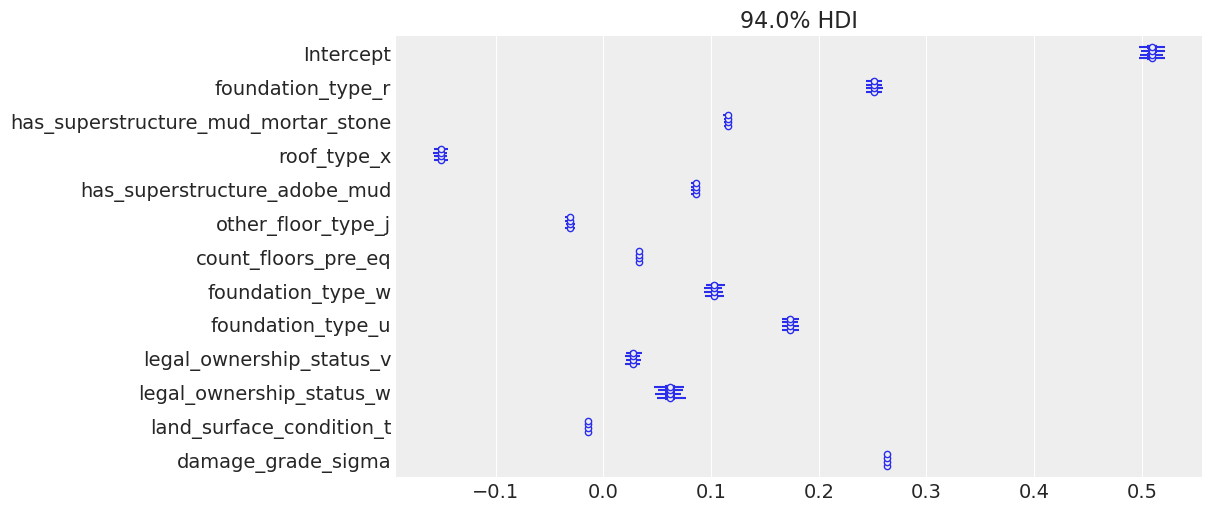

In [86]:
#forest plots
az.plot_forest(fitted_damage_model, figsize = (12,5))

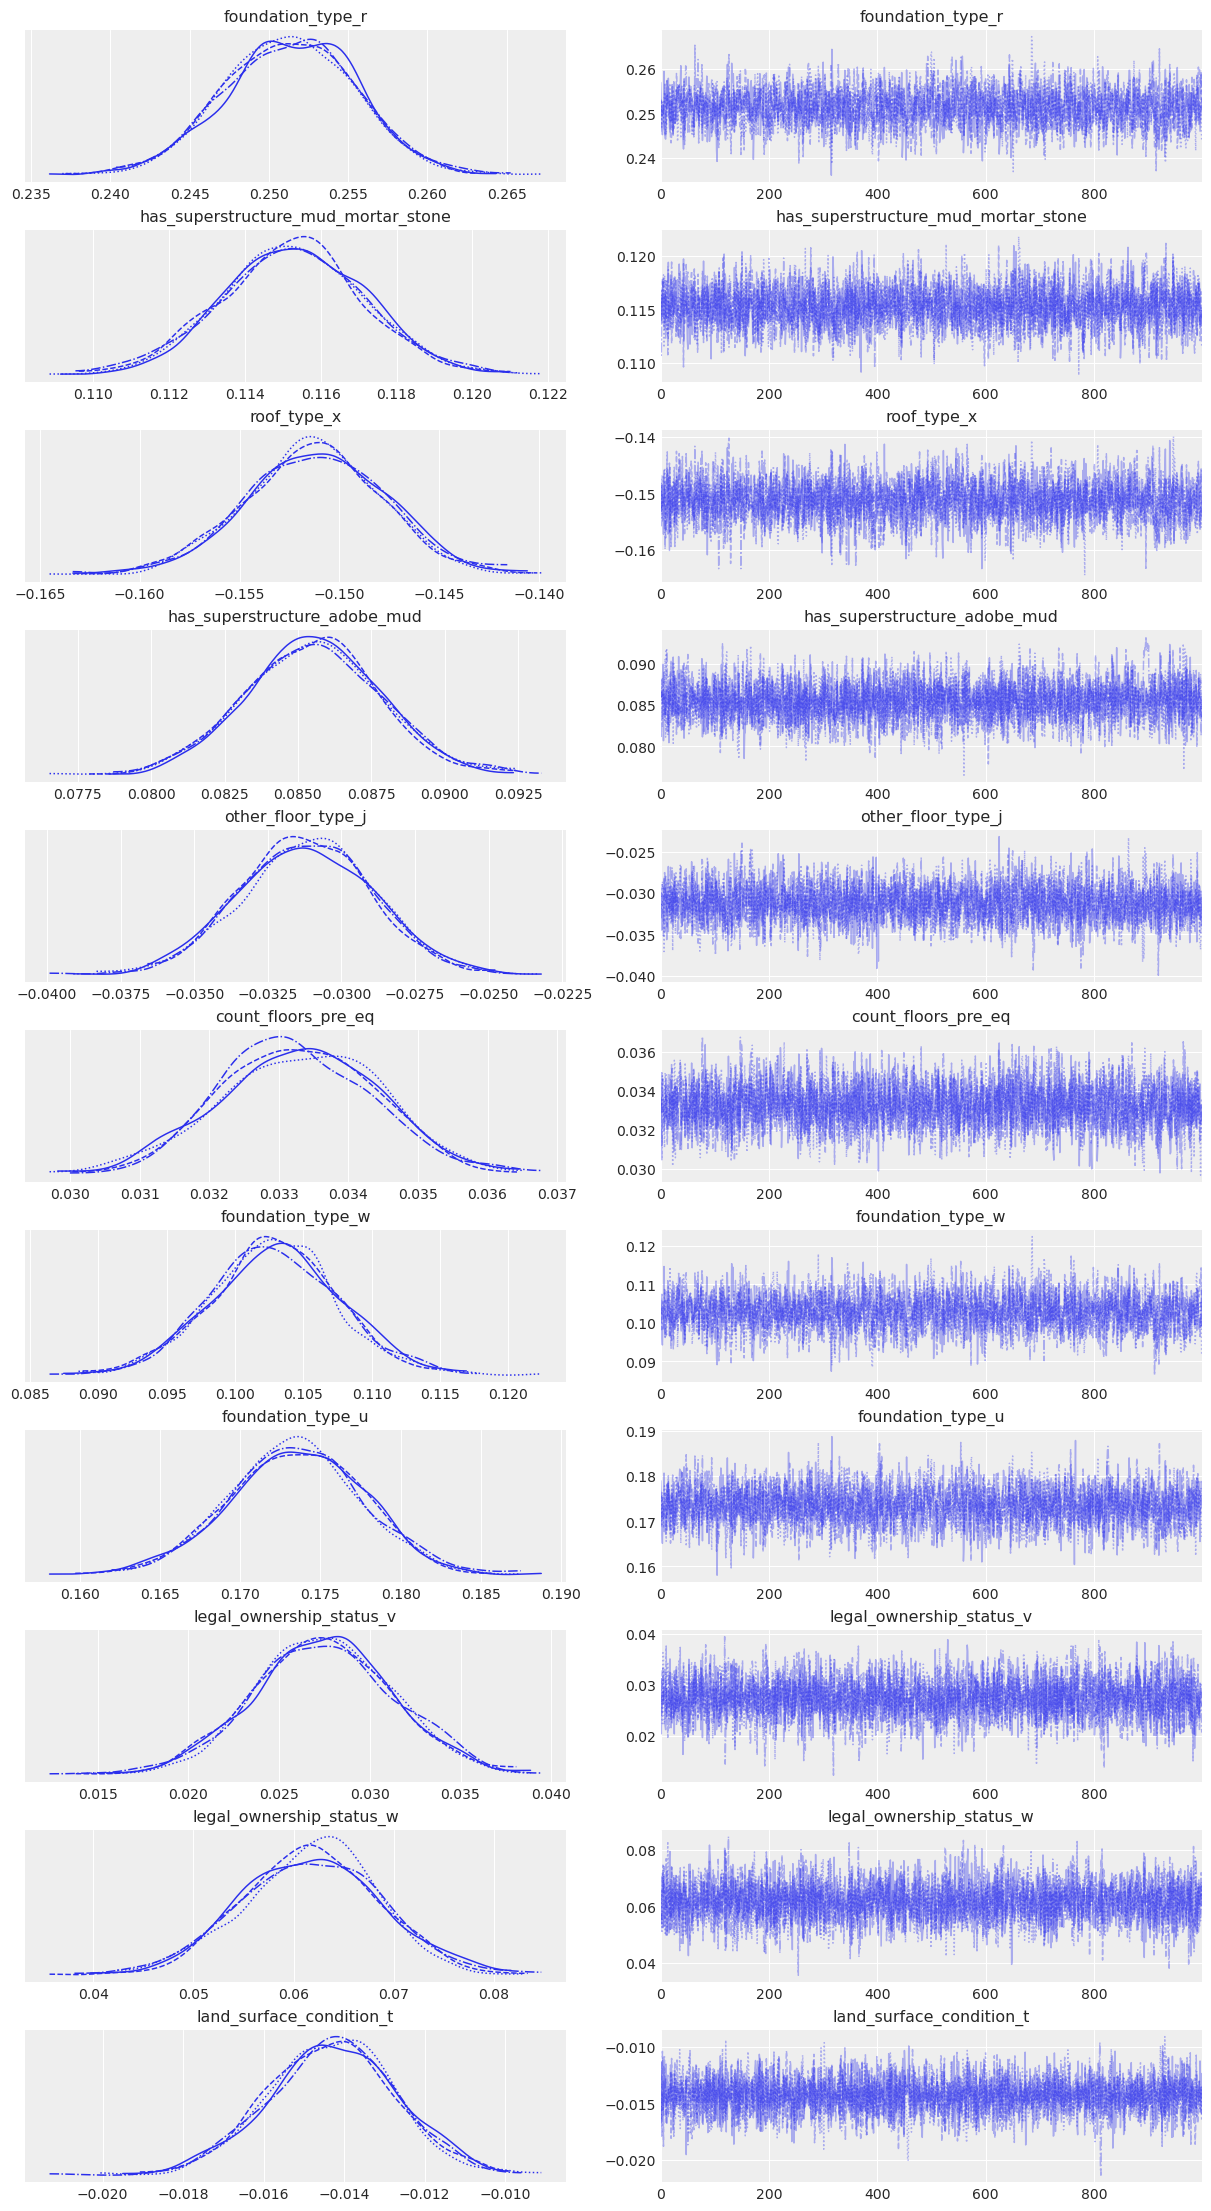

In [88]:
#Trace and density plots 
az.plot_trace(fitted_damage_model, var_names=('foundation_type_r', 'has_superstructure_mud_mortar_stone', 'roof_type_x', 'has_superstructure_adobe_mud', 'other_floor_type_j', 'count_floors_pre_eq', 'foundation_type_w', 'foundation_type_u', 'legal_ownership_status_v', 'legal_ownership_status_w', 'land_surface_condition_t'))
plt.show()

### Analysis

When running the MCMC, only 11 of the features were used, due to the high computing power needed for MCMC. When running the model using NUTS, 4 chains were used, and no divergences were found. This can also be seen in the trace plots. The trace plots of the MCMC sample show that the sampler converges. There is no evidence of there being divergent chains

When looking at the density plots, each feature examined has a bell shaped curve of the posterior distribution. The feature with the smallest negative posterior distribution is ‘count_floors_pre_eq’, with a value of about -0.310. The feature with the smallest positive posterior distribution is ‘legal_ownership_status_w’, with a value of about 0.027. The feature with the largest positive posterior distribution is ‘foundation_type_r’, with a value of about 0.252. This information aligns with the observations from the exploratory data analysis, which suggest that ‘foundation_type_r’ may be one of the most important features for predicting the damage grade of buildings from the earthquake. 


________________________________________________________________________________________________________________

## Conclusion


LDA, QDA, and Logistic Regression models were run using the Nepal earthquake building damage data, to determine which model best predicts the damage grade of each building. The analysis of both LDA and QDA shows strong evidence against these models being used for building damage grade predictions. LDA performed very poorly, with its best prediction accuracy rate being 43.9% on the training data, and 11.1% on the testing data. The QDA model performed even more poorly, with its best prediction accuracy rate being 25.1% on the training data, and 6.5% on the testing data. Therefore, LDA and QDA should not be used in predicting building damage levels for this earthquake dataset. 

Logistic Regression by far performed the best of the three models. The highest performing model, which contained 18 features, had a prediction accuracy of 90.9% on the training data, and 90.8% on the testing data. Based on this outcome, Logistic Regression would be a good choice for making predictions on building damage grades. 

| Accuracy | Training Data | Testing Data |
|----------|---------------|--------------|
| LDA | 43.9% | 11.1% |
| QDA | 25.1% | 6.5% |
| Logistic Regression | 90.9% | 90.8% |
| BMA | 90.9% | 90.8% |

Due to time constraints, no further models have been examined at this time. However, running similar model analysis and predictive checks on other types of models is highly recommended. Since Logistic Regression was so successful, Multinomial Regression would also likely be successful, and thus worth exploration. More complex models may also be worth exploring, since the data is extensive and multi-faceted. 

The goal of this project was to use Bayesian Data Analysis to find the best model for predicting damage grade of buildings affected by the 2015 Nepal earthquake. Ideally, this work could be applied to other similar use cases, and shed light on the patterns of damage caused by earthquakes, and how to prevent such destruction in impoverished communities. 

________________________________________________________________________________________________________________

### References
- *Pymc.io online documentation and examples*: 
    https://www.pymc.io/projects/examples/en/latest/gallery.html; 
    https://www.pymc.io/projects/examples/en/latest/samplers/MLDA_simple_linear_regression.html
- *Kaggle Bill Basener BMA & Logistic Regressoin notebook*: https://www.kaggle.com/billbasener/bayesian-model-averaging-logistic-regression
- *DS 6040 Course Content*: https://github.com/tbrown122387/ds-6040
- *Toward Data Science - Logistic Regression*: https://towardsdatascience.com/introduction-to-bayesian-logistic-regression-7e39a0bae691
- Hinne, Max, Gronau, Quentin, et al. 2020. Sage Journals. *A Conceptual Introduction to Bayesian Model Averaging*: https://journals.sagepub.com/doi/full/10.1177/2515245919898657
- Srivastava, Santosh et al. *Bayesian Quadratic Discriminant Analysis*. Journal of Machine Learning Research 8, 2007.  https://www.jmlr.org/papers/volume8/srivastava07a/srivastava07a.pdf



##### Honor Code: I pledge that this work is my own.